In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn
import pickle
import seaborn as sns

from model_evaluation import metrics_regression, test_different_models, print_scoretable

from train_test_split import train_test_split_as_requested

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

## Getting data from pickle files dumped in notebook 1

In [2]:
with open("random_reviews.p","rb") as f:
    random_reviews = pickle.load( f )

with open("bow1000.p","rb") as f:
    bow1000 = pickle.load( f )

## Testing of different scikit-learn models in predicting column "useful" based on bag of words and other features

Section consists of following parts:
- Testing models on normalized data
- Testing models with data projected through principal components, i.e. utilizing PCA
- After some feature engineering:
    - Splitting date column to years, months, weekdays and days
    - Representing time transformed to unit circle to allow models to see the true cyclical nature of the feature

### Models tested with normalized data
- ensemble methods Random Forest and AdaBoost with decision trees are in the league of their own

In [3]:
# Combining two dataframes to one
joined_df = pd.concat([random_reviews.add_prefix("random_reviews_"),bow1000], axis=1)

# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


In [4]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date'], axis=1), joined_df['random_reviews_useful']






In [5]:
features.head(10)

,random_reviews_cool,random_reviews_funny,random_reviews_stars,random_reviews_category,able,absolutely,accommodating,across,actually,add,...,writing,wrong,year,years,yelp,yes,yet,young,yum,yummy
0,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
modelsToTest=[
  ("LinearRegression", sklearn.linear_model.LinearRegression(), 0.5),
  ("SVM regressor - linear", LinearSVR(max_iter=-1)), 
  ("SVM regressor - RBF kernel", SVR(kernel='rbf', max_iter=-1)),
  ("DecisionTreeRegressor", DecisionTreeRegressor(max_depth=10,min_samples_split=20)),
  ("RandomForestRegressor",RandomForestRegressor(n_estimators=100)),
  ("AdaBoostRegressor", AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=100))
]

In [7]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))



# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)
scores_basecase = scores.copy()
scores_basecase.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_basecase.rename(columns={'Mean squared error':'MSE basecase'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1084), y_train.shape: (800, 1)
N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.2,0.55,-0.41
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.18,0.32,0.18
DecisionTreeRegressor,0.45,0.21,0.45
RandomForestRegressor,0.54,0.18,0.54
AdaBoostRegressor,0.6,0.16,0.6


### Transforming a dataset with PCA, then testing models again
- all measures are on a lower level than without PCA
    - the loss of data weighs more than than benefit from linearly independent features

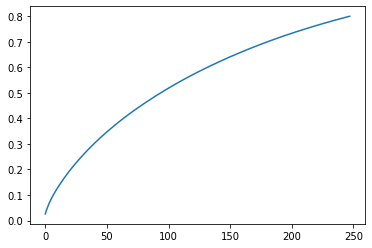

In [8]:
# PCA
pca = PCA(0.8)
pca.fit(X_train_scaled)


# Plotting how large part of variance explained
explained = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(len(explained)),explained)
plt.show()

X_train_pca, X_test_pca = pca.transform(X_train_scaled), pca.transform(X_test_scaled)

In [9]:
prediction_table = test_different_models(X_train_pca, X_test_pca, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_basecase_pca = scores.copy()
scores_basecase_pca.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_basecase_pca.rename(columns={'Mean squared error':'MSE basecase with PCA'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:21 Time:  0:00:21


Model,Explained variance,Mean squared error,R2 score
DecisionTreeRegressor,-0.054,0.41,-0.055
LinearRegression,0.11,0.39,-0.015
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
AdaBoostRegressor,0.091,0.37,0.039
SVM regressor - RBF kernel,0.13,0.34,0.12
RandomForestRegressor,0.19,0.32,0.19


### Further testing on done on data where date split to new columns
- in practice no difference compared to data where data column has been dropped, i.e. adding years, months and so on didn't add value
- the statistical significance of differences was not tested

In [10]:
# Splitting date column into separate columns
joined_df["month"] = joined_df['random_reviews_date'].map(lambda x: x.month)
joined_df["year"] = joined_df['random_reviews_date'].map(lambda x: x.year)
joined_df["day"] = joined_df['random_reviews_date'].map(lambda x: x.day)
joined_df["weekday"] = joined_df['random_reviews_date'].map(lambda x: x.weekday())
joined_df["hour"] = joined_df['random_reviews_date'].map(lambda x: x.hour)

# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


In [11]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date'], axis=1), joined_df['random_reviews_useful']






In [12]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)


# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_datesplit = scores.copy()
scores_datesplit.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_datesplit.rename(columns={'Mean squared error':'MSE date column split'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1085), y_train.shape: (800, 1)
N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:13 Time:  0:00:13


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.11,0.51,-0.3
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.18,0.32,0.18
DecisionTreeRegressor,0.36,0.25,0.35
RandomForestRegressor,0.59,0.16,0.59
AdaBoostRegressor,0.62,0.15,0.61


### Further testing - splitting cyclical data into sin and cos time
- in practice no difference compared to data where data column has been dropped, i.e. projecting time to unit circle didn't add value
- the statistical significance of differences was not tested 

In [13]:
joined_df["seconds"] = joined_df['random_reviews_date'].map(lambda x: x.hour * 60 * 60 + x.minute * 60 + x.second)

# Splitting seconds into 24h sin and cos time
# Taken from https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
seconds_in_day = 24*60*60
joined_df['sin_time'] = np.sin(2*np.pi*joined_df["seconds"]/seconds_in_day)
joined_df['cos_time'] = np.cos(2*np.pi*joined_df["seconds"]/seconds_in_day)

weekdays_in_week = 7
joined_df['sin_weekday'] = np.sin(2*np.pi*joined_df["weekday"]/weekdays_in_week)
joined_df['cos_weekday'] = np.cos(2*np.pi*joined_df["weekday"]/weekdays_in_week)

months_in_year = 12
joined_df['sin_month'] = np.sin(2*np.pi*joined_df["month"]/months_in_year)
joined_df['cos_month'] = np.cos(2*np.pi*joined_df["month"]/months_in_year)


# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


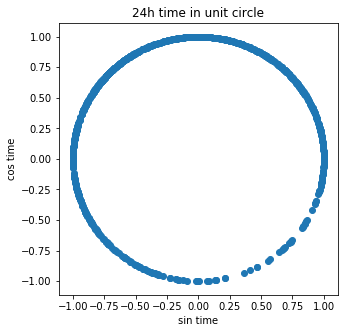

In [14]:
#Plotting sin and cos time
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('sin time')
ax.set_ylabel('cos time')
ax.set_title('24h time in unit circle')
ax.scatter(joined_df['sin_time'],joined_df['cos_time'])

plt.show()

In [15]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date','seconds','month','weekday'], axis=1), joined_df['random_reviews_useful']






In [16]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_sin_cos_time = scores.copy()
scores_sin_cos_time.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_sin_cos_time.rename(columns={'Mean squared error':'MSE sin/cos-time'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1089), y_train.shape: (800, 1)
C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:13 Time:  0:00:13


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.099,0.51,-0.3
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.19,0.32,0.18
DecisionTreeRegressor,0.35,0.25,0.35
RandomForestRegressor,0.49,0.2,0.49
AdaBoostRegressor,0.65,0.14,0.64


### Visualising the predictions of AdaBoost and Random Forest in comparison to true values
- observing differences is difficult

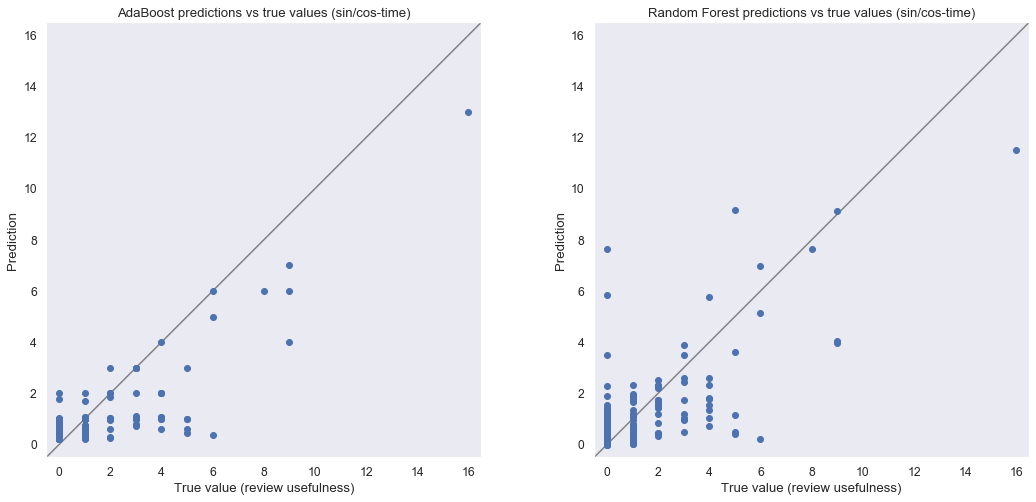

In [17]:
sns.set(font_scale=1.1)

# Plotting scatter, predicted and true values for Random Forest and AdaBoost
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax1.set_xlabel('True value (review usefulness)')
ax1.set_ylabel('Prediction')
ax1.set_title('AdaBoost predictions vs true values (sin/cos-time)')
ax1.plot([-0.5,16.5],[-0.5,16.5], 'k-', alpha=0.5, zorder=0)
ax1.set_aspect('equal')
ax1.set_ylim(-0.5,16.5)
ax1.set_xlim(-0.5,16.5)
ax1.grid()
ax1.scatter(scaler_y.inverse_transform(prediction_table['True value']),scaler_y.inverse_transform(prediction_table['AdaBoostRegressor']))




ax2.set_xlabel('True value (review usefulness)')
ax2.set_ylabel('Prediction')
ax2.set_title('Random Forest predictions vs true values (sin/cos-time)')
ax2.plot([-0.5,16.5],[-0.5,16.5], 'k-', alpha=0.5, zorder=0)
ax2.set_aspect('equal')
ax2.set_ylim(-0.5,16.5)
ax2.set_xlim(-0.5,16.5)
ax2.grid()
ax2.scatter(scaler_y.inverse_transform(prediction_table['True value']),scaler_y.inverse_transform(prediction_table['RandomForestRegressor']))


plt.show()

### Testing for overfitting - error in train set - to be compared with train data scores

In [18]:
prediction_table = test_different_models(X_train_scaled, X_train_scaled, y_train_scaled.flatten(), y_train_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)
# prediction_table["Train Y Median"] = np.median(y_train_scaled)


scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_sin_cos_train = scores.copy()
scores_sin_cos_train.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_sin_cos_train.rename(columns={'Mean squared error':'MSE sin/cos-time training'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


Model,Explained variance,Mean squared error,R2 score
SVM regressor - linear,0,1,0
--Average value from training data--,0,1,0
LinearRegression,0.33,0.68,0.32
SVM regressor - RBF kernel,0.45,0.56,0.44
DecisionTreeRegressor,0.9,0.1,0.9
RandomForestRegressor,0.9,0.096,0.9
AdaBoostRegressor,0.99,0.011,0.99



### Plotting training and testing error as function of tree max depth - AdaBoost and Decision Tree
- As expected, Decision Tree overfits right away whereas AdaBoost is very robust

In [19]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)

results_df = pd.DataFrame()

for number_trees in range(1,50,2):

  modelsToTest=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(max_depth=number_trees,min_samples_split=10)),
    ("AdaBoostRegressor", AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=number_trees), n_estimators=50))
    ]

  # MSE from test
  prediction_table_test = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
  scores_test = metrics_regression(prediction_table_test)
  scores_test = scores_test.sort_values(by=['Mean squared error'], ascending=False)
  scores_test.drop(['R2 score','Explained variance'],axis=1,inplace=True)
  scores_test["Number of trees"] = number_trees
  scores_test["Train or test"] = "Test"

  # MSE from train
  prediction_table_train = test_different_models(X_train_scaled, X_train_scaled, y_train_scaled.flatten(), y_train_scaled.flatten(), modelsToTest)
  scores_train = metrics_regression(prediction_table_train)
  scores_train = scores_train.sort_values(by=['Mean squared error'], ascending=False)
  scores_train.drop(['R2 score','Explained variance'],axis=1,inplace=True)
  scores_train["Number of trees"] = number_trees
  scores_train["Train or test"] = "Train"

  frames = [results_df, scores_test, scores_train]

  results_df = pd.concat(frames)



N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1089), y_train.shape: (800, 1)
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (2 of 2) |#############

In [20]:
results_df.head()

,Model,Mean squared error,Number of trees,Train or test
1,AdaBoostRegressor,5.950805,1,Test
0,DecisionTreeRegressor,0.258295,1,Test
1,AdaBoostRegressor,6.247422,1,Train
0,DecisionTreeRegressor,0.685226,1,Train
1,AdaBoostRegressor,0.889884,3,Test


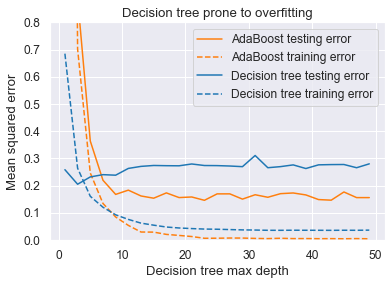

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#fig.set_size(10,10)

ax.set_xlabel('Decision tree max depth')
ax.set_ylabel('Mean squared error')
ax.set_title('Decision tree prone to overfitting')

ax.plot(results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Test'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Test'), 'Mean squared error' ] ,
        label='AdaBoost testing error', color='#FF7F0E')
ax.plot(results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Train'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Train'), 'Mean squared error' ] ,
        label='AdaBoost training error', linestyle='dashed',color='#FF7F0E')

ax.plot(results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Test'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Test'), 'Mean squared error' ] ,
        label='Decision tree testing error', color='#1F77B4')

ax.plot(results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Train'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Train'), 'Mean squared error' ] ,
        label='Decision tree training error', linestyle='dashed', color='#1F77B4')

plt.ylim(0,0.8)

plt.legend()

plt.show()

### Joining results from different datasets
- AdaBoost and Decision Trees have bigger gap between training data and test data performance - higher generalisation error
- Random Forest generalizes better
- Other models were strugling with the highly collinear data that had more columns than rows

In [22]:
all_results = scores_basecase.join([scores_basecase_pca.drop(['Model'],axis=1),
                                    scores_datesplit.drop(['Model'],axis=1),scores_sin_cos_time.drop(['Model'],axis=1),
                                    scores_sin_cos_train.drop(['Model'],axis=1)])
all_results = all_results.sort_values(by=['MSE basecase'], ascending=True)
print_scoretable(all_results, columns=all_results.columns[1:])

Model,MSE basecase,MSE basecase with PCA,MSE date column split,MSE sin/cos-time,MSE sin/cos-time training
AdaBoostRegressor,0.16,0.37,0.15,0.14,0.011
RandomForestRegressor,0.18,0.32,0.16,0.2,0.096
DecisionTreeRegressor,0.21,0.41,0.25,0.25,0.1
SVM regressor - RBF kernel,0.32,0.34,0.32,0.32,0.56
SVM regressor - linear,0.39,0.39,0.39,0.39,1
--Average value from training data--,0.39,0.39,0.39,0.39,1
LinearRegression,0.55,0.39,0.51,0.51,0.68


### Visualising one tree from Random Forest

In [23]:
# Instantiating the model
rf = RandomForestRegressor(n_estimators=100)
model = rf.fit(X_train_scaled, y_train_scaled.flatten())



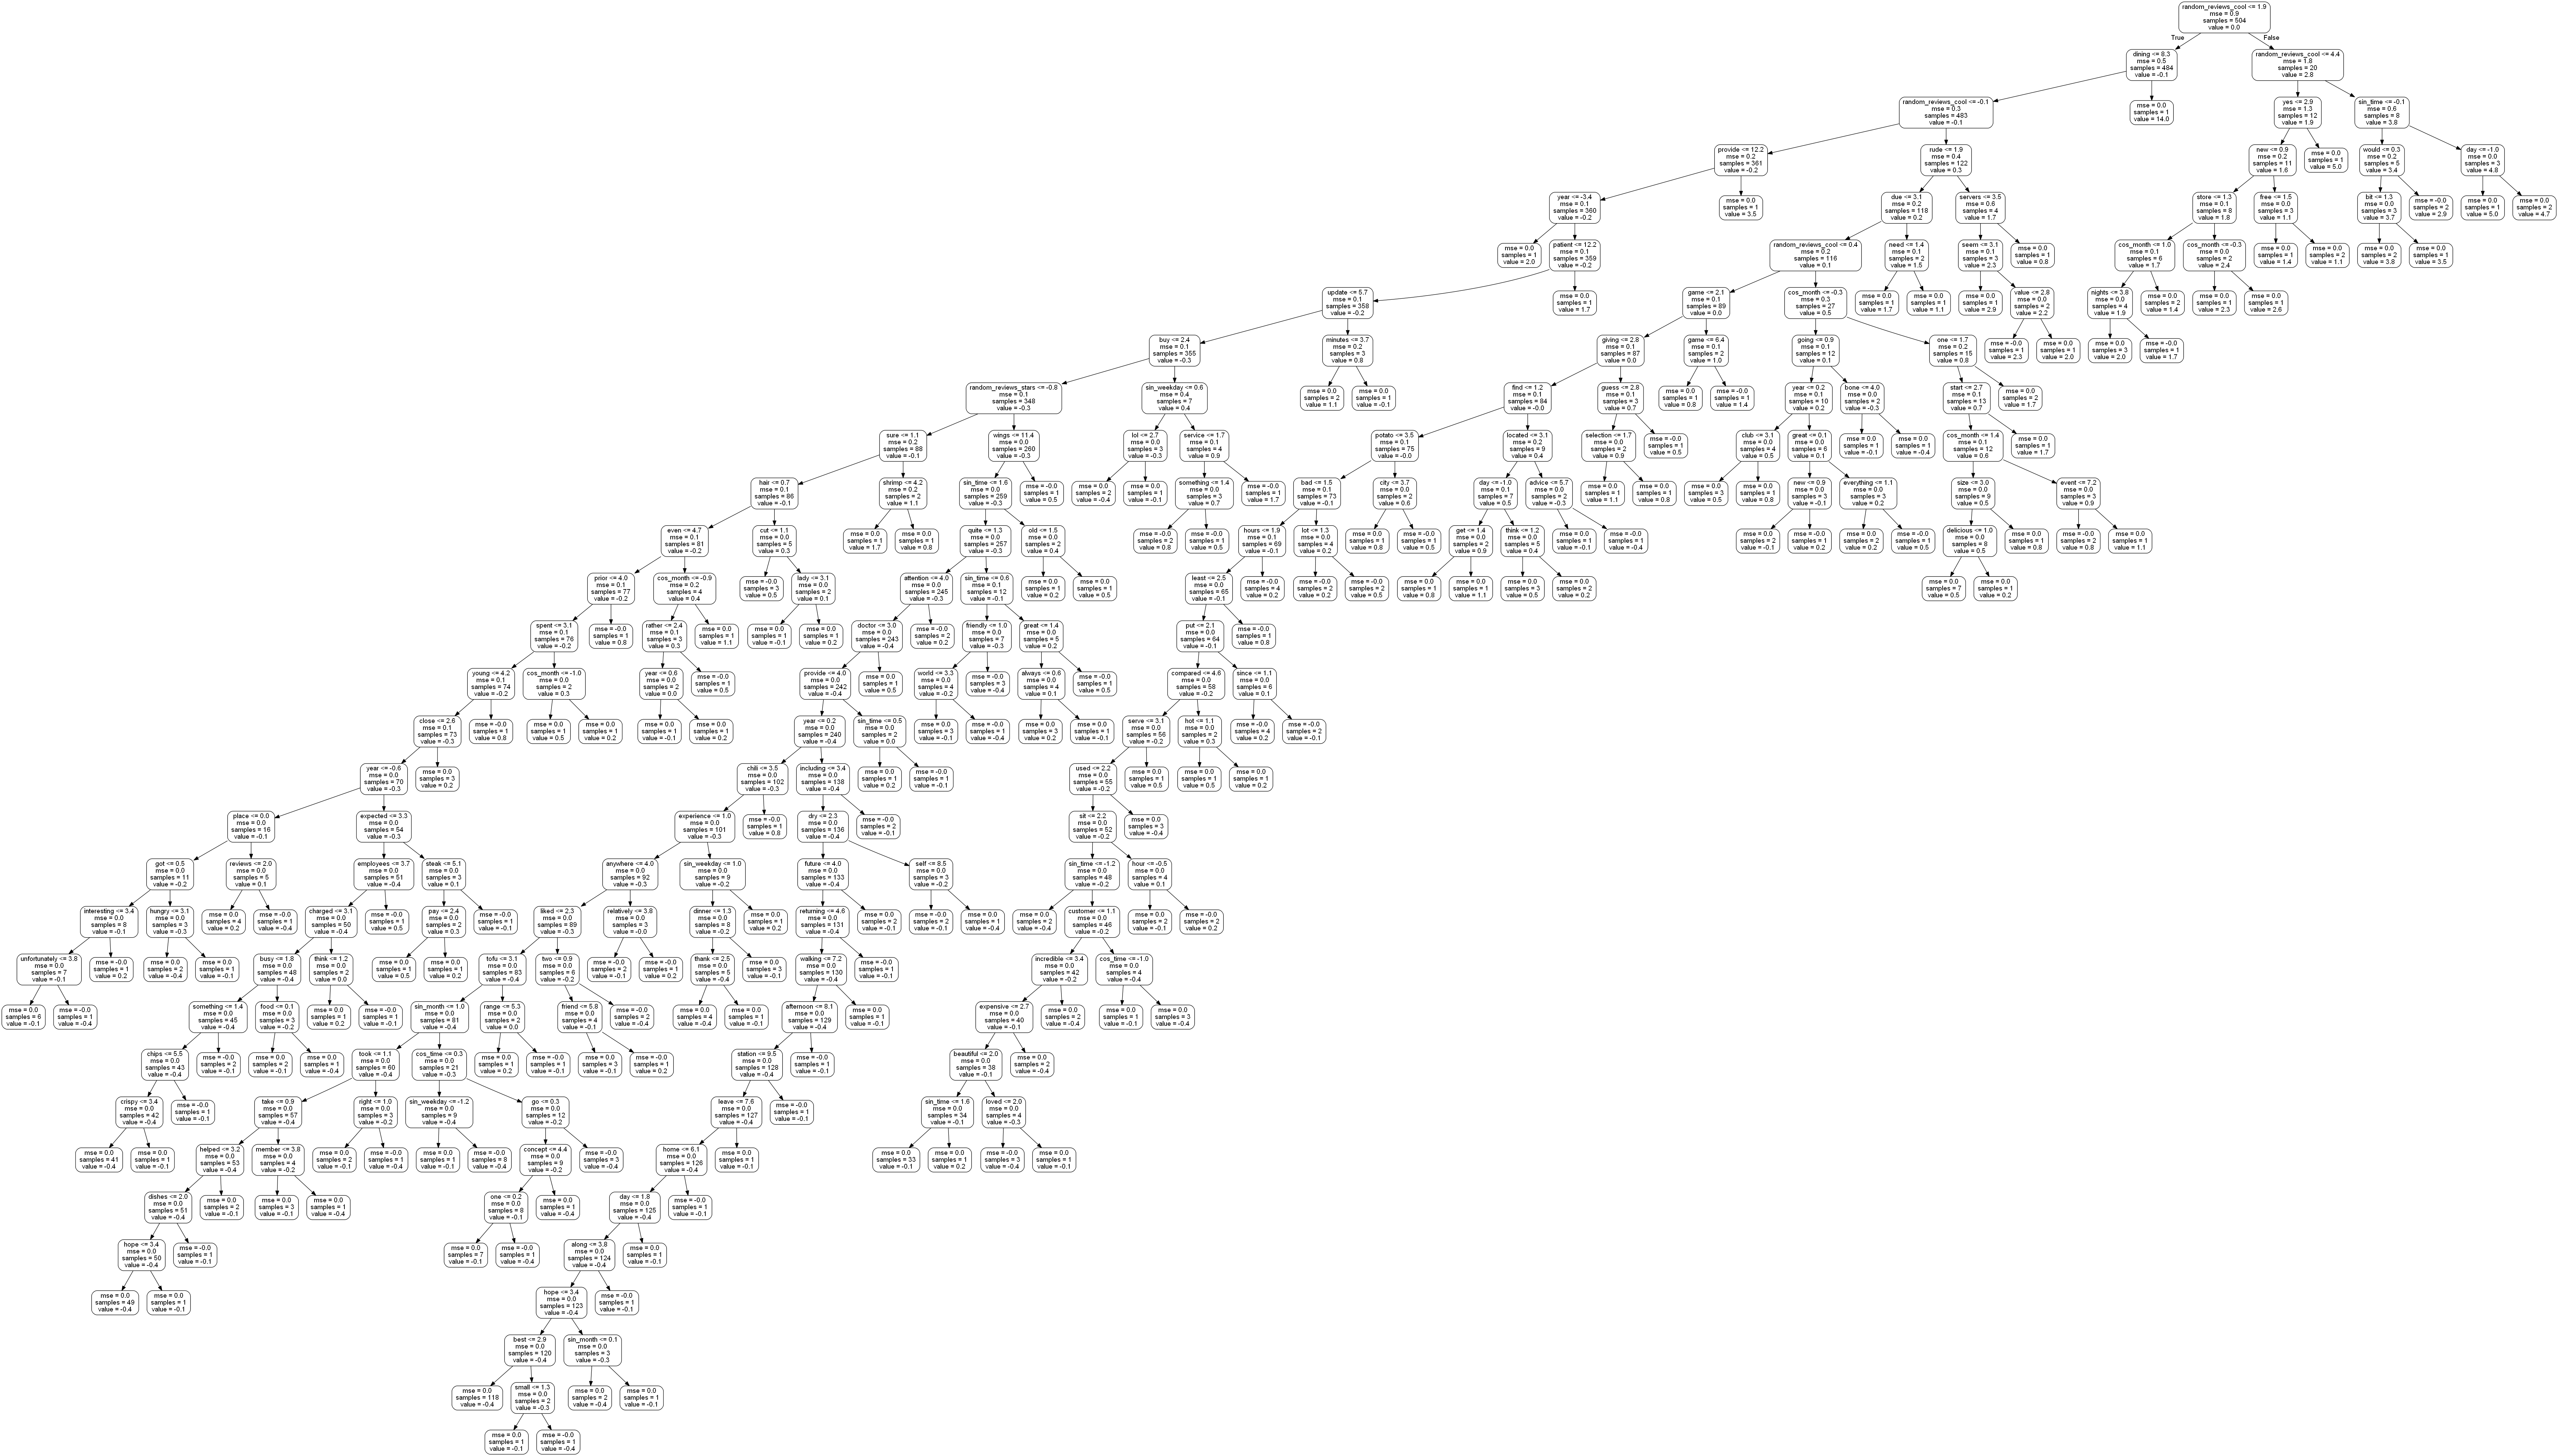

In [24]:

#Visualising one tree
feature_list = features.columns

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list,  rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


from IPython.display import Image
Image("tree.png", width=5000,height=5000)